#Imports

In [263]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [468]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import f_oneway
from scipy.stats import sem
import matplotlib.ticker as mtick
from sklearn import metrics
from sklearn.tree import export_graphviz
import pydot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [265]:
contacts = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/contacts.csv", sep=',')

In [266]:
contacts.head(1)

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first,dim_room_type,dim_total_reviews,dim_person_capacity,dim_guest_language,dim_host_language
0,56d70d7c-1d0a-4594-a250-ed62f7cf7ac4,65a56b50-faf2-44a2-845f-0c467f41d720,4deeb033-183e-437c-b94c-851ffee8cec8,2013-01-13 21:03:07.0,2013-01-14 21:19:42.0,2013-01-14 21:19:42.0,2013-01-14 21:19:42.0,2013-01-18,2013-01-20,2.0,13,165.0,book_it,Private room,78,2,NaN,es


In [267]:
print("Shape: ")
print(contacts.shape)
print("\n")
print("Types:")
print(contacts.dtypes)

Shape: 
(23143, 18)


Types:
id_guest_anon                            object
id_host_anon                             object
id_listing_anon                          object
ts_interaction_first                     object
ts_reply_at_first                        object
ts_accepted_at_first                     object
ts_booking_at                            object
ds_checkin_first                         object
ds_checkout_first                        object
m_guests_first                          float64
m_interactions                            int64
m_first_message_length_in_characters    float64
dim_contact_channel_first                object
dim_room_type                            object
dim_total_reviews                         int64
dim_person_capacity                       int64
dim_guest_language                      float64
dim_host_language                        object
dtype: object


#Información General del DataSet

In [270]:
print("Guests: "+str( len(contacts.groupby(["id_guest_anon"])) ) )
print("Hosts: "+str( len(contacts.groupby(["id_host_anon"])) ) )
print("Listings: "+str( len(contacts.groupby(["id_listing_anon"])) ) )

Guests: 18179
Hosts: 2118
Listings: 3172


Formatting

In [271]:
contacts['ts_interaction_first'] = pd.to_datetime(contacts['ts_interaction_first'], format='%Y%m%d %H:%M:%S')
contacts['ts_reply_at_first'] = pd.to_datetime(contacts['ts_reply_at_first'], format='%Y%m%d %H:%M:%S')
contacts['ts_accepted_at_first'] = pd.to_datetime(contacts['ts_accepted_at_first'], format='%Y%m%d %H:%M:%S')
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'], format='%Y%m%d %H:%M:%S')
contacts['ds_checkin_first'] = pd.to_datetime(contacts['ds_checkin_first'], format='%Y%m%d ')
contacts['ds_checkout_first'] = pd.to_datetime(contacts['ds_checkout_first'], format='%Y%m%d ')

contacts.m_guests_first = contacts.m_guests_first.fillna(0).astype(int)
contacts.m_first_message_length_in_characters = contacts.m_first_message_length_in_characters.fillna(0).astype(int)

Drop columnas vacías

In [272]:
contacts.drop(columns="dim_guest_language", inplace=True)
contacts.drop(columns="dim_host_language", inplace=True)

Traducción de features

In [273]:
contacts['host_replied'] = contacts['ts_reply_at_first'].apply(lambda x: 1 if pd.notnull(x) else 0)
contacts['guest_accepted'] = contacts['ts_accepted_at_first'].apply(lambda x: 1 if pd.notnull(x) else 0)

contacts['diff_reply_interaction'] = contacts['ts_reply_at_first'] - contacts['ts_interaction_first']

contacts['stay'] = (contacts['ds_checkout_first'] - contacts['ds_checkin_first']).dt.days

contacts['diff_checkin_interaction'] = (contacts['ds_checkin_first'] - contacts['ts_interaction_first']).dt.days

contacts['interaction_hour'] = contacts['ts_interaction_first'].dt.hour

contacts['checkin_weekday'] = contacts['ds_checkin_first'].dt.weekday
contacts['interaction_weekday'] = contacts['ts_interaction_first'].dt.weekday

contacts['checkin_month'] = contacts['ds_checkin_first'].dt.month
contacts['interaction_month'] = contacts['ts_interaction_first'].dt.month

contacts['dim_contact_channel_first'] = contacts['dim_contact_channel_first'].factorize()[0]
contacts['dim_room_type'] = contacts['dim_room_type'].factorize()[0]

contacts['diff_reply_interaction'] = contacts['diff_reply_interaction'].apply( lambda x: int(x.seconds//60) if pd.notnull(x) else -1)

#Catindad de veces que una persona ha sido aceptada/denegada
#times_guest_accepted = contacts.groupby(['id_guest_anon','guest_accepted']).size()
#times_guest_accepted
#contacts['times_guest_refused'] = 

In [274]:
print("Shape: ")
print(contacts.shape[0])
print("\n")
print("Types:")
print(contacts.dtypes)

Shape: 
23143


Types:
id_guest_anon                                   object
id_host_anon                                    object
id_listing_anon                                 object
ts_interaction_first                    datetime64[ns]
ts_reply_at_first                       datetime64[ns]
ts_accepted_at_first                    datetime64[ns]
ts_booking_at                           datetime64[ns]
ds_checkin_first                        datetime64[ns]
ds_checkout_first                       datetime64[ns]
m_guests_first                                   int64
m_interactions                                   int64
m_first_message_length_in_characters             int64
dim_contact_channel_first                        int64
dim_room_type                                    int64
dim_total_reviews                                int64
dim_person_capacity                              int64
host_replied                                     int64
guest_accepted                            

In [275]:
contacts

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first,dim_room_type,dim_total_reviews,dim_person_capacity,host_replied,guest_accepted,diff_reply_interaction,stay,diff_checkin_interaction,interaction_hour,checkin_weekday,interaction_weekday,checkin_month,interaction_month
0,56d70d7c-1d0a-4594-a250-ed62f7cf7ac4,65a56b50-faf2-44a2-845f-0c467f41d720,4deeb033-183e-437c-b94c-851ffee8cec8,2013-01-13 21:03:07,2013-01-14 21:19:42,2013-01-14 21:19:42,2013-01-14 21:19:42,2013-01-18,2013-01-20,2,13,165,0,0,78,2,1,1,16,2,4,21,4,6,1,1
1,dcfb93c4-07ca-41e8-b134-89b49ddc7a36,65a56b50-faf2-44a2-845f-0c467f41d720,4deeb033-183e-437c-b94c-851ffee8cec8,2013-01-15 23:43:49,2013-01-16 09:04:37,2013-01-16 09:04:37,2013-01-16 09:04:37,2013-01-23,2013-01-25,2,5,0,0,0,78,2,1,1,560,2,7,23,2,1,1,1
2,aef63ee0-7fd8-449f-867d-e710c39694e1,65a56b50-faf2-44a2-845f-0c467f41d720,4deeb033-183e-437c-b94c-851ffee8cec8,2013-03-19 21:30:13,2013-03-20 12:50:49,2013-03-20 12:50:49,2013-03-20 12:50:49,2013-05-31,2013-06-03,2,7,350,0,0,78,2,1,1,920,3,72,21,4,1,5,3
3,58788b6f-1215-40a5-8fb0-75d2e399880c,65a56b50-faf2-44a2-845f-0c467f41d720,4deeb033-183e-437c-b94c-851ffee8cec8,2013-01-03 16:32:01,2013-01-03 17:02:13,2013-01-03 17:02:53,2013-01-03 17:02:53,2013-02-09,2013-02-11,2,5,426,0,0,78,2,1,1,30,2,36,16,5,3,2,1
4,c3945c48-53b6-4e19-8bda-7d5b51d14ec1,65a56b50-faf2-44a2-845f-0c467f41d720,4deeb033-183e-437c-b94c-851ffee8cec8,2013-04-13 04:31:33,2013-04-13 16:43:53,2013-04-13 16:44:20,2013-04-13 16:44:20,2013-06-06,2013-06-08,2,7,239,0,0,78,2,1,1,732,2,53,4,3,5,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23138,a248e7ba-08f6-49cc-abd8-95c9428297ab,7e1fb44c-38eb-4604-97ff-33931a41854b,c47d9f4e-64d4-4d5c-bf1a-8a5fec2aacb1,2013-11-22 10:00:57,2013-11-22 10:54:16,2013-11-22 10:54:16,2013-11-22 10:54:16,2013-11-30,2013-12-02,3,7,241,0,1,15,4,1,1,53,2,7,10,5,4,11,11
23139,0222a967-45e1-4dcb-bba4-80b5820dbc0b,6a4c0608-ef83-498e-82eb-e6012654bf9e,1dfa10cf-20d2-453a-8e6d-e96e59b6914e,2013-12-17 16:44:39,NaT,NaT,NaT,2013-12-19,2014-02-28,1,1,190,0,1,0,2,0,0,-1,71,1,16,3,1,12,12
23140,f4b31fd1-4c19-488b-a493-1a1461cdb780,9027c38e-345f-44e7-acf4-533a6c6ef121,844b3cc5-c8de-4f66-a0f4-fc2fe8ec1cac,2013-12-19 10:49:38,NaT,NaT,NaT,2013-12-30,2014-01-02,2,2,282,0,1,0,2,0,0,-1,3,10,10,0,3,12,12
23141,69e69670-aaa0-4674-b89b-487aba872ff2,2407b713-a09b-4a85-aa08-9e5d6d6e0ad6,aa06e97f-e852-4228-9720-14ff9ae67991,2013-12-24 04:58:01,2013-12-24 16:09:15,NaT,NaT,2013-12-31,2014-01-02,2,10,215,0,1,63,2,1,0,671,2,6,4,1,1,12,12


In [276]:
numeric_contacts = contacts.drop(columns=["id_guest_anon","id_host_anon","id_listing_anon","ts_interaction_first","ts_reply_at_first","ts_accepted_at_first","ts_booking_at","ds_checkin_first","ds_checkout_first"])

In [277]:
print("Shape: ")
print(numeric_contacts.shape[0])
print("\n")
print("Types:")
print(numeric_contacts.dtypes)
numeric_contacts

Shape: 
23143


Types:
m_guests_first                          int64
m_interactions                          int64
m_first_message_length_in_characters    int64
dim_contact_channel_first               int64
dim_room_type                           int64
dim_total_reviews                       int64
dim_person_capacity                     int64
host_replied                            int64
guest_accepted                          int64
diff_reply_interaction                  int64
stay                                    int64
diff_checkin_interaction                int64
interaction_hour                        int64
checkin_weekday                         int64
interaction_weekday                     int64
checkin_month                           int64
interaction_month                       int64
dtype: object


,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first,dim_room_type,dim_total_reviews,dim_person_capacity,host_replied,guest_accepted,diff_reply_interaction,stay,diff_checkin_interaction,interaction_hour,checkin_weekday,interaction_weekday,checkin_month,interaction_month
0,2,13,165,0,0,78,2,1,1,16,2,4,21,4,6,1,1
1,2,5,0,0,0,78,2,1,1,560,2,7,23,2,1,1,1
2,2,7,350,0,0,78,2,1,1,920,3,72,21,4,1,5,3
3,2,5,426,0,0,78,2,1,1,30,2,36,16,5,3,2,1
4,2,7,239,0,0,78,2,1,1,732,2,53,4,3,5,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23138,3,7,241,0,1,15,4,1,1,53,2,7,10,5,4,11,11
23139,1,1,190,0,1,0,2,0,0,-1,71,1,16,3,1,12,12
23140,2,2,282,0,1,0,2,0,0,-1,3,10,10,0,3,12,12
23141,2,10,215,0,1,63,2,1,0,671,2,6,4,1,1,12,12


#Correlations

<u>Kendall correlation</u>

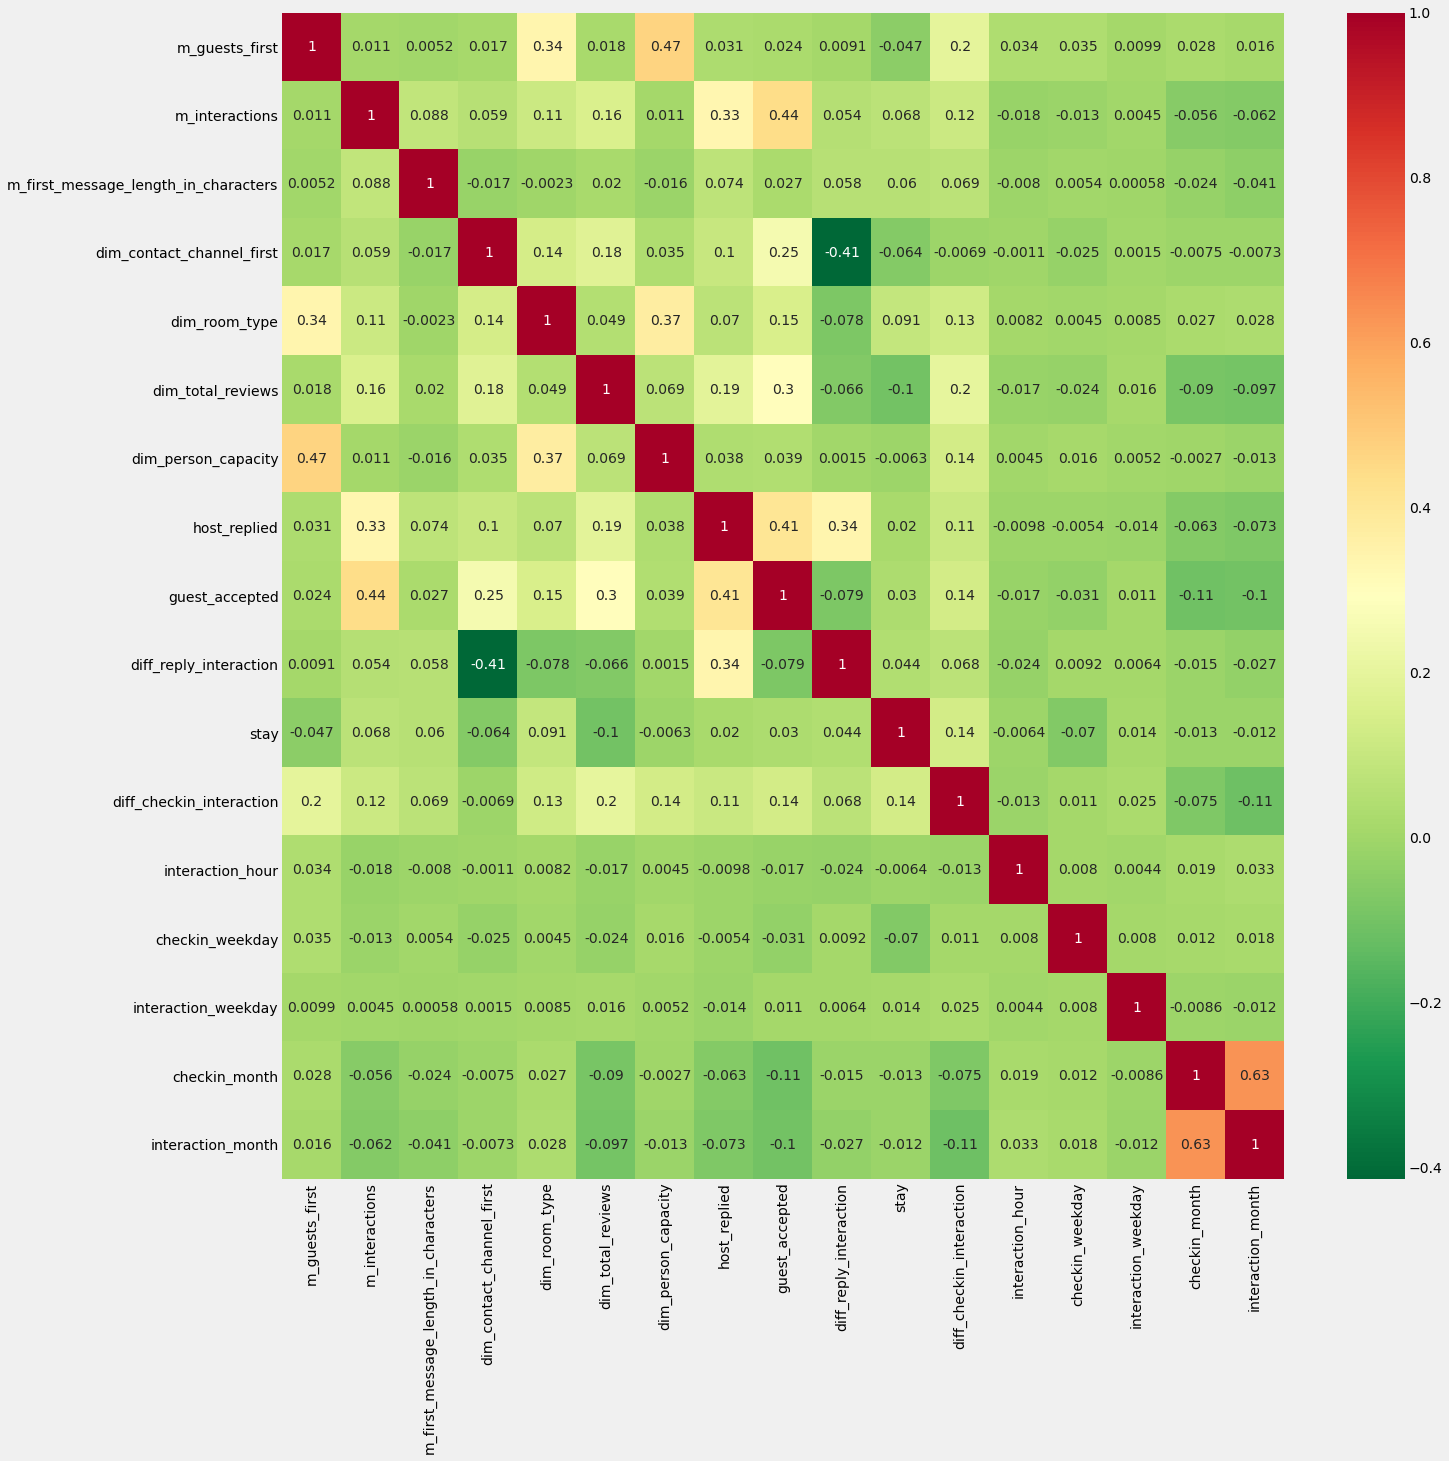

In [278]:
contacts_kendall_corr_matrix = numeric_contacts.corr("kendall")
plt.figure(figsize=(20,20))
g=sns.heatmap(contacts_kendall_corr_matrix,annot=True,cmap="RdYlGn_r")

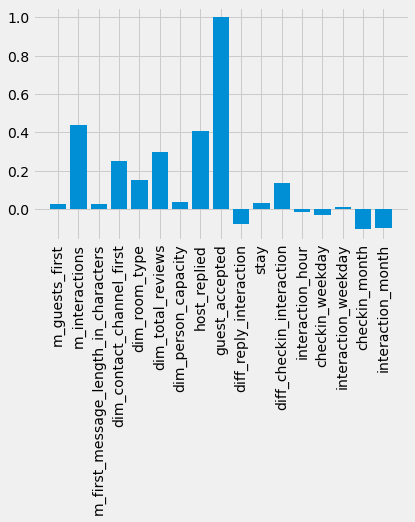

In [279]:
accepted_kendall_corr = contacts_kendall_corr_matrix['guest_accepted']
plt.bar(accepted_kendall_corr.index, accepted_kendall_corr.values )
plt.xticks(rotation=90)
plt.show()

<u>Point-biserial correlation</u>

In [280]:
accepted_point_biserial_corr = []
for feature in numeric_contacts.columns.values:
  accepted_point_biserial_corr.append(pointbiserialr(numeric_contacts['guest_accepted'],numeric_contacts[feature])[0])

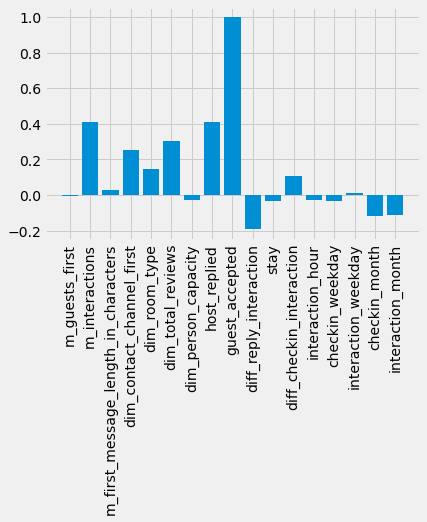

In [281]:
plt.bar(numeric_contacts.columns.values, accepted_point_biserial_corr )
plt.xticks(rotation=90)
plt.show()

#m_guests_first

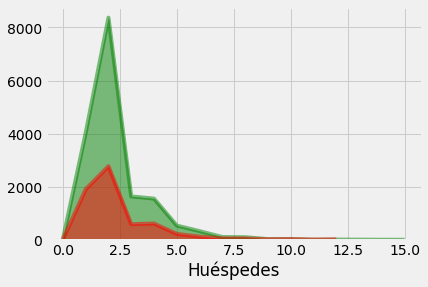

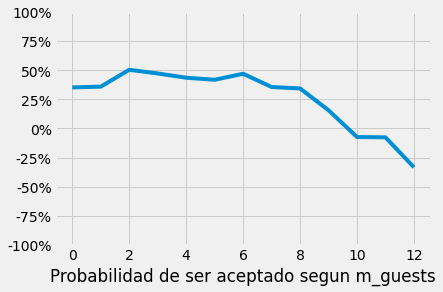

Para inquiries con 0 m_guests:
67.57% fueron aceptados
32.43% no fueron aceptados


In [282]:
m_guests_first_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['m_guests_first']]
m_guests_first_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['m_guests_first']]


m_guests_first_by_accepted_guests.groupby("m_guests_first").size().plot(x=[i for i in range(70)], y='size',kind='area',xlabel='Huéspedes',color='green',alpha=0.5)
m_guests_first_by_refused_guests.groupby("m_guests_first").size().plot(x=[i for i in range(70)], y='size',kind='area',xlabel='Huéspedes',color='red',alpha=0.5)
plt.show()

m_guests_first_by_accepted_guests_none=m_guests_first_by_accepted_guests[m_guests_first_by_accepted_guests['m_guests_first']==0]
m_guests_first_by_refused_guests_none=m_guests_first_by_refused_guests[m_guests_first_by_refused_guests['m_guests_first']==0]

prob_accepted_m_guests = 100*(m_guests_first_by_accepted_guests.groupby("m_guests_first").size() - m_guests_first_by_refused_guests.groupby("m_guests_first").size()) / (m_guests_first_by_accepted_guests.groupby("m_guests_first").size()+m_guests_first_by_refused_guests.groupby("m_guests_first").size())
ax = prob_accepted_m_guests.plot(x=range(1400),y=range(100),kind='line',xlabel='Probabilidad de ser aceptado segun m_guests')
ax.set_ylim([-100,100])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

print('Para inquiries con 0 m_guests:')
print(str(round(m_guests_first_by_accepted_guests_none.shape[0]*100/(m_guests_first_by_accepted_guests_none.shape[0]+m_guests_first_by_refused_guests_none.shape[0]),2)) + "% fueron aceptados")
print(str(round(m_guests_first_by_refused_guests_none.shape[0]*100/(m_guests_first_by_accepted_guests_none.shape[0]+m_guests_first_by_refused_guests_none.shape[0]),2)) + "% no fueron aceptados")

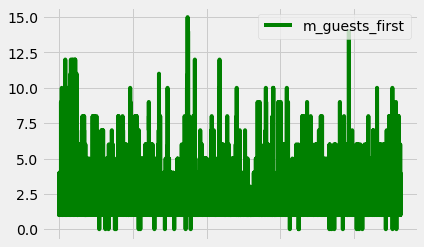

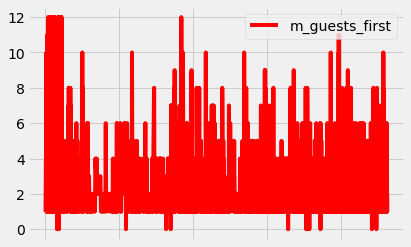

In [283]:
m_guests_first_by_accepted_guests.plot(color='green')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
m_guests_first_by_refused_guests.plot(color='red')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

<u>Accepted Guests</u>

In [284]:
print("Promedio: "+str(round(m_guests_first_by_accepted_guests.mean().values[0],2))+"\n")
print("Min: "+str(m_guests_first_by_accepted_guests.min().values[0])+"\n")
print("Max: "+str(m_guests_first_by_accepted_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(m_guests_first_by_accepted_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(m_guests_first_by_accepted_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(m_guests_first_by_accepted_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(m_guests_first_by_accepted_guests.mode().values[0][0])+"\n")

Promedio: 2.31

Min: 0

Max: 15

Primer cuartil: 2

Median: 2

Tercer cuartil: 3

Moda: 2



<u>Refused Guests </u>

In [285]:
print("Promedio: "+str(round(m_guests_first_by_refused_guests.mean().values[0],2))+"\n")
print("Min: "+str(m_guests_first_by_refused_guests.min().values[0])+"\n")
print("Max: "+str(m_guests_first_by_refused_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(m_guests_first_by_refused_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(m_guests_first_by_refused_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuaril: "+str(round(m_guests_first_by_refused_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(m_guests_first_by_refused_guests.mode().values[0][0])+"\n")

Promedio: 2.34

Min: 0

Max: 12

Primer cuartil: 1

Median: 2

Tercer cuaril: 3

Moda: 2



#m_interactions

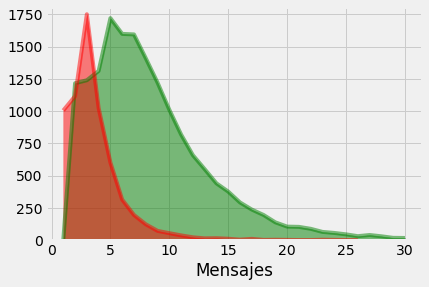

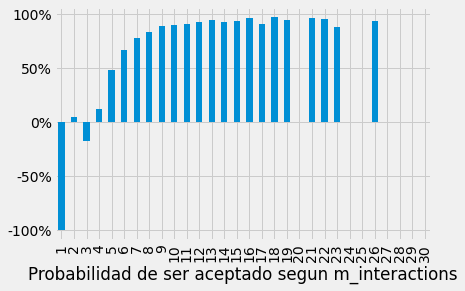

Hay mas de 75% de probabilidad de ser aceptado mandando más de 7 mensajes
Hay aprox. 20% de probabilidad de no ser aceptado si se mandan exactamente3 mensajes


In [286]:
m_interactions_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['m_interactions']]
m_interactions_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['m_interactions']]

m_interactions_by_accepted_guests = m_interactions_by_accepted_guests[m_interactions_by_accepted_guests['m_interactions']<=30]
m_interactions_by_refused_guests = m_interactions_by_refused_guests[m_interactions_by_refused_guests['m_interactions']<=30]


m_interactions_by_accepted_guests.groupby("m_interactions").size().plot(x=[i for i in range(70)], y='size',kind='area',xlabel='Mensajes',color='green',alpha=0.5)
m_interactions_by_refused_guests.groupby("m_interactions").size().plot(x=[i for i in range(70)], y='size',kind='area',xlabel='Mensajes',color='red', alpha=0.5)
plt.show()


prob_accepted_m_interactions = 100*(m_interactions_by_accepted_guests.groupby("m_interactions").size()- m_interactions_by_refused_guests.groupby("m_interactions").size()) / (m_interactions_by_accepted_guests.groupby("m_interactions").size()+m_interactions_by_refused_guests.groupby("m_interactions").size())
ax = prob_accepted_m_interactions.plot(x=[i for i in range(30)],y=range(100),kind='bar',xlabel='Probabilidad de ser aceptado segun m_interactions')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

print("Hay mas de 75% de probabilidad de ser aceptado mandando más de 7 mensajes")
print("Hay aprox. 20% de probabilidad de no ser aceptado si se mandan exactamente3 mensajes")

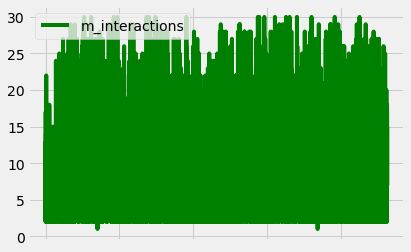

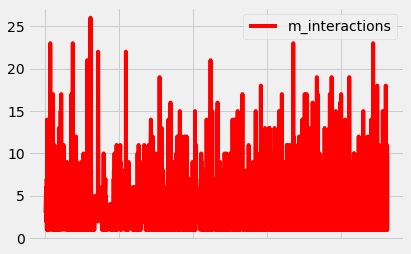

In [287]:
m_interactions_by_accepted_guests.plot(color='green')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
m_interactions_by_refused_guests.plot(color='red')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

<u>Accepted guests</u>

In [288]:
print("Promedio: "+str(round(m_interactions_by_accepted_guests.mean().values[0],2))+"\n")
print("Min: "+str(m_interactions_by_accepted_guests.min().values[0])+"\n")
print("Max: "+str(m_interactions_by_accepted_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(m_interactions_by_accepted_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(m_interactions_by_accepted_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(m_interactions_by_accepted_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(m_interactions_by_accepted_guests.mode().values[0][0])+"\n")

Promedio: 8.3

Min: 1

Max: 30

Primer cuartil: 5

Median: 7

Tercer cuartil: 11

Moda: 5



<u>Refused guests</u>

In [289]:
print("Promedio: "+str(round(m_interactions_by_refused_guests.mean().values[0],2))+"\n")
print("Min: "+str(m_interactions_by_refused_guests.min().values[0])+"\n")
print("Max: "+str(m_interactions_by_refused_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(m_interactions_by_refused_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(m_interactions_by_refused_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuaril: "+str(round(m_interactions_by_refused_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(m_interactions_by_refused_guests.mode().values[0][0])+"\n")

Promedio: 3.59

Min: 1

Max: 26

Primer cuartil: 2

Median: 3

Tercer cuaril: 4

Moda: 3



#m_first_message_lenght

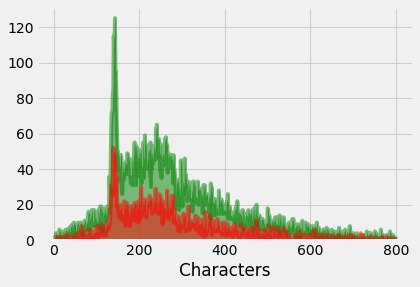

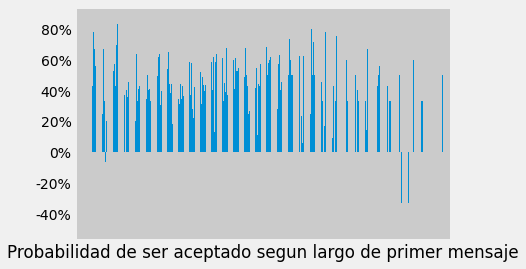

In [290]:
m_first_message_length_in_characters_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['m_first_message_length_in_characters']]
m_first_message_length_in_characters_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['m_first_message_length_in_characters']]

m_first_message_length_in_characters_by_accepted_guests = m_first_message_length_in_characters_by_accepted_guests[(m_first_message_length_in_characters_by_accepted_guests['m_first_message_length_in_characters']!=0)&(m_first_message_length_in_characters_by_accepted_guests['m_first_message_length_in_characters']<=800)]
m_first_message_length_in_characters_by_refused_guests = m_first_message_length_in_characters_by_refused_guests[(m_first_message_length_in_characters_by_refused_guests['m_first_message_length_in_characters']!=0)&(m_first_message_length_in_characters_by_refused_guests['m_first_message_length_in_characters']<=800)]


m_first_message_length_in_characters_by_accepted_guests.groupby("m_first_message_length_in_characters").size().plot(y='size',kind='area',xlabel='Characters',color='green',alpha=0.5)
m_first_message_length_in_characters_by_refused_guests.groupby("m_first_message_length_in_characters").size().plot(y='size',kind='area',xlabel='Characters',color='red', alpha=0.5)
plt.show()


prob_accepted_m_first_message_length_in_characters = 100*(m_first_message_length_in_characters_by_accepted_guests.groupby("m_first_message_length_in_characters").size()- m_first_message_length_in_characters_by_refused_guests.groupby("m_first_message_length_in_characters").size()) / (m_first_message_length_in_characters_by_accepted_guests.groupby("m_first_message_length_in_characters").size()+m_first_message_length_in_characters_by_refused_guests.groupby("m_first_message_length_in_characters").size())
ax = prob_accepted_m_first_message_length_in_characters.plot(y=range(100),kind='bar',xlabel='Probabilidad de ser aceptado segun largo de primer mensaje')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[]

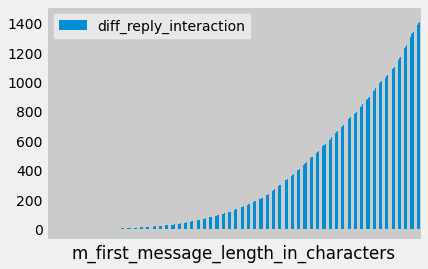

In [361]:
m_first_message_length_in_characters_by_diff_reply_interaction = numeric_contacts[['m_first_message_length_in_characters','diff_reply_interaction','guest_accepted']]
m_first_message_length_in_characters_by_diff_reply_interaction.loc[m_first_message_length_in_characters_by_diff_reply_interaction['guest_accepted'] == 0, 'guest_accepted'] = -1
m_first_message_length_in_characters_by_diff_reply_interaction = m_first_message_length_in_characters_by_diff_reply_interaction[(m_first_message_length_in_characters_by_diff_reply_interaction['m_first_message_length_in_characters']!=0)&(m_first_message_length_in_characters_by_refused_guests['m_first_message_length_in_characters']<=800)]

m_first_message_length_in_characters_by_diff_reply_interaction.sort_values(by="diff_reply_interaction").plot(y='diff_reply_interaction',x='m_first_message_length_in_characters',kind='bar')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.plot()

<u>Accepted Guests</u>

In [350]:
print("Promedio: "+str(round(m_first_message_length_in_characters_by_accepted_guests.mean().values[0],2))+"\n")
print("Min: "+str(m_first_message_length_in_characters_by_accepted_guests.min().values[0])+"\n")
print("Max: "+str(m_first_message_length_in_characters_by_accepted_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(m_first_message_length_in_characters_by_accepted_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(m_first_message_length_in_characters_by_accepted_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(m_first_message_length_in_characters_by_accepted_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(m_first_message_length_in_characters_by_accepted_guests.mode().values[0][0])+"\n")

Promedio: 279.78

Min: 1

Max: 800

Primer cuartil: 173

Median: 249

Tercer cuartil: 354

Moda: 143



<u>Refused Guests</u>

In [351]:
print("Promedio: "+str(round(m_first_message_length_in_characters_by_refused_guests.mean().values[0],2))+"\n")
print("Min: "+str(m_first_message_length_in_characters_by_refused_guests.min().values[0])+"\n")
print("Max: "+str(m_first_message_length_in_characters_by_refused_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(m_first_message_length_in_characters_by_refused_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(m_first_message_length_in_characters_by_refused_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(m_first_message_length_in_characters_by_refused_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(m_first_message_length_in_characters_by_refused_guests.mode().values[0][0])+"\n")

Promedio: 272.49

Min: 3

Max: 800

Primer cuartil: 169

Median: 242

Tercer cuartil: 342

Moda: 139



#dim_contact_channel_first

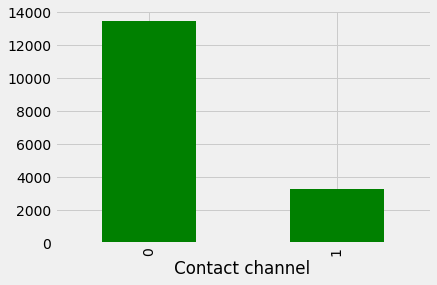

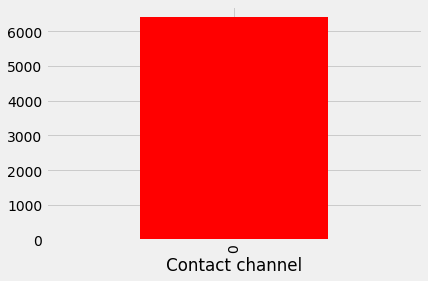

In [291]:
#0=Bookit
#1=Instant
contact_channel_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['dim_contact_channel_first']]
contact_channel_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['dim_contact_channel_first']]

contact_channel_by_accepted_guests.groupby("dim_contact_channel_first").size().plot(kind='bar',xlabel='Contact channel',color='green')
plt.show()
contact_channel_by_refused_guests.groupby("dim_contact_channel_first").size().plot(kind='bar',xlabel='Contact channel',color='red')
plt.show()


In [292]:
print( str(round(contact_channel_by_accepted_guests.groupby('dim_contact_channel_first').size()[1]*100/contact_channel_by_accepted_guests.shape[0],2))+ "% de los usuarios aceptados tomaron Instant Book" )
print("El 100% que tomó instant book fue aceptada. (probablemente evidente)")
print("Esta feature puede no tener causalidad y causar fuerte ruido, pensar seriamente en quitar")
numeric_contacts.drop(columns=['dim_contact_channel_first'],inplace=True)

19.62% de los usuarios aceptados tomaron Instant Book
El 100% que tomó instant book fue aceptada. (probablemente evidente)
Esta feature puede no tener causalidad y causar fuerte ruido, pensar seriamente en quitar


#dim_room_type

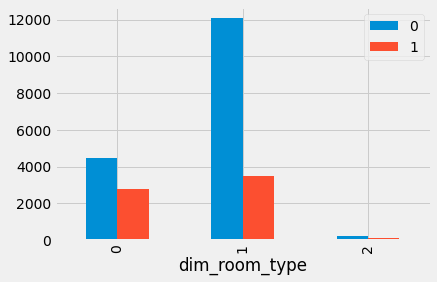

62% de las personas que escojieron   Private Room  fueron aceptadas
78% de las personas que escojieron   Entire home fueron aceptadas
62% de las personas que escojieron   Shared Room fueron aceptadas


In [293]:
#0=Private Room
#1=Entire home
#2= Shared Room

dim_room_type_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['dim_room_type']]
dim_room_type_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['dim_room_type']]

bothdf = pd.concat([dim_room_type_by_accepted_guests.groupby("dim_room_type").size(), dim_room_type_by_refused_guests.groupby("dim_room_type").size()], axis=1, ignore_index=True)
bothdf.plot.bar()
plt.show()


print(str(round(dim_room_type_by_accepted_guests.groupby("dim_room_type").size()[0]*100/ (dim_room_type_by_accepted_guests.groupby("dim_room_type").size()[0] + dim_room_type_by_refused_guests.groupby("dim_room_type").size()[0])))+"% de las personas que escojieron   Private Room  fueron aceptadas")
print(str(round(dim_room_type_by_accepted_guests.groupby("dim_room_type").size()[1]*100/ (dim_room_type_by_accepted_guests.groupby("dim_room_type").size()[1] + dim_room_type_by_refused_guests.groupby("dim_room_type").size()[1])))+"% de las personas que escojieron   Entire home fueron aceptadas")
print(str(round(dim_room_type_by_accepted_guests.groupby("dim_room_type").size()[2]*100/ (dim_room_type_by_accepted_guests.groupby("dim_room_type").size()[2] + dim_room_type_by_refused_guests.groupby("dim_room_type").size()[2]))) +"% de las personas que escojieron   Shared Room fueron aceptadas")

#dim_total_reviews

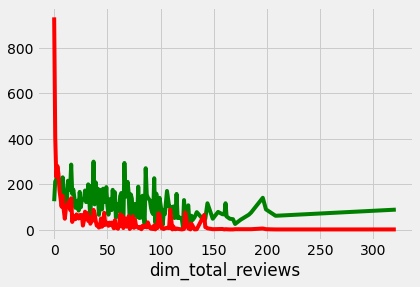

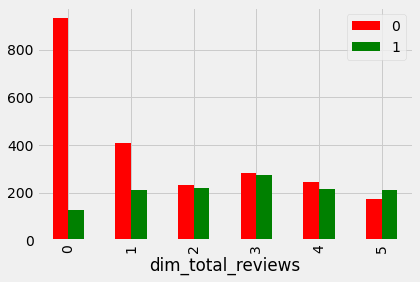

In [294]:
dim_total_reviews_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['dim_total_reviews']]
dim_total_reviews_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['dim_total_reviews']]

dim_total_reviews_by_accepted_guests.groupby('dim_total_reviews').size().plot(kind='line', color='g')
dim_total_reviews_by_refused_guests.groupby('dim_total_reviews').size().plot(kind='line', color='r')
plt.show()


df = pd.concat([dim_total_reviews_by_refused_guests[dim_total_reviews_by_refused_guests['dim_total_reviews']<=5].groupby('dim_total_reviews').size(),dim_total_reviews_by_accepted_guests[dim_total_reviews_by_accepted_guests['dim_total_reviews']<=5].groupby('dim_total_reviews').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()


In [295]:
print(str(round(dim_total_reviews_by_refused_guests[dim_total_reviews_by_refused_guests['dim_total_reviews']<=1].shape[0]*100 / dim_total_reviews_by_refused_guests.shape[0]))+"% de los guest que son refused, lo son en listings de 1 review o menos")
print("Solo " +str(round(dim_total_reviews_by_accepted_guests[dim_total_reviews_by_accepted_guests['dim_total_reviews']<=1].shape[0]*100 / dim_total_reviews_by_accepted_guests.shape[0]))+"% de los guest que son aceptados, lo son en listings de 1 review o menos")


21% de los guest que son refused, lo son en listings de 1 review o menos
Solo 2% de los guest que son aceptados, lo son en listings de 1 review o menos


<u>Accepted Guests</u>

In [347]:
print("Promedio: "+str(round(dim_total_reviews_by_accepted_guests.mean().values[0],2))+"\n")
print("Min: "+str(dim_total_reviews_by_accepted_guests.min().values[0])+"\n")
print("Max: "+str(dim_total_reviews_by_accepted_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(dim_total_reviews_by_accepted_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(dim_total_reviews_by_accepted_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(dim_total_reviews_by_accepted_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(dim_total_reviews_by_accepted_guests.mode().values[0][0])+"\n")

Promedio: 62.98

Min: 0

Max: 321

Primer cuartil: 24

Median: 54

Tercer cuartil: 90

Moda: 37



<u>Refused Guests</u>

In [349]:
print("Promedio: "+str(round(dim_total_reviews_by_refused_guests.mean().values[0],2))+"\n")
print("Min: "+str(dim_total_reviews_by_refused_guests.min().values[0])+"\n")
print("Max: "+str(dim_total_reviews_by_refused_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(dim_total_reviews_by_refused_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(dim_total_reviews_by_refused_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(dim_total_reviews_by_refused_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(dim_total_reviews_by_refused_guests.mode().values[0][0])+"\n")

Promedio: 29.63

Min: 0

Max: 321

Primer cuartil: 3

Median: 14

Tercer cuartil: 46

Moda: 0



#dim_person_capacity

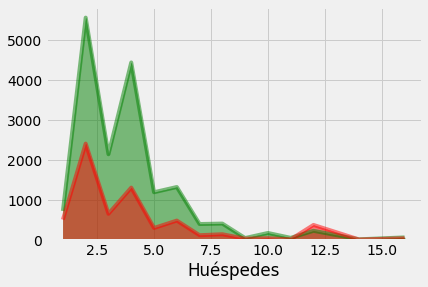

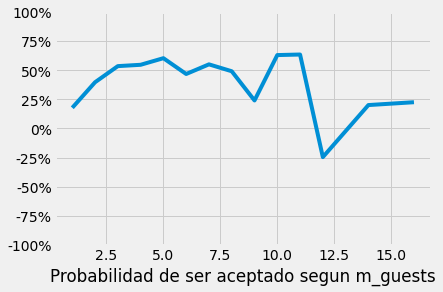

In [296]:
dim_person_capacity_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['dim_person_capacity']]
dim_person_capacity_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['dim_person_capacity']]


dim_person_capacity_by_accepted_guests.groupby("dim_person_capacity").size().plot(x=[i for i in range(70)], y='size',kind='area',xlabel='Huéspedes',color='green',alpha=0.5)
dim_person_capacity_by_refused_guests.groupby("dim_person_capacity").size().plot(x=[i for i in range(70)], y='size',kind='area',xlabel='Huéspedes',color='red',alpha=0.5)
plt.show()

dim_person_capacity_by_accepted_guests_none=dim_person_capacity_by_accepted_guests[dim_person_capacity_by_accepted_guests['dim_person_capacity']==0]
dim_person_capacity_by_refused_guests_none=dim_person_capacity_by_refused_guests[dim_person_capacity_by_refused_guests['dim_person_capacity']==0]

prob_accepted_m_guests = 100*(dim_person_capacity_by_accepted_guests.groupby("dim_person_capacity").size() - dim_person_capacity_by_refused_guests.groupby("dim_person_capacity").size()) / (dim_person_capacity_by_accepted_guests.groupby("dim_person_capacity").size()+dim_person_capacity_by_refused_guests.groupby("dim_person_capacity").size())
ax = prob_accepted_m_guests.plot(x=range(1400),y=range(100),kind='line',xlabel='Probabilidad de ser aceptado segun m_guests')
ax.set_ylim([-100,100])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


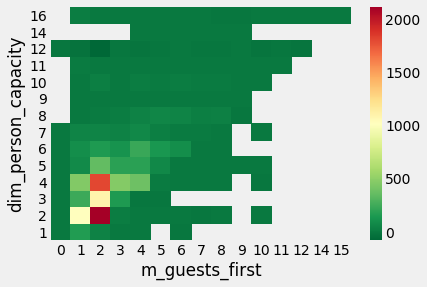

In [297]:
dim_person_capacity_by_m_guests_first = numeric_contacts[['dim_person_capacity','m_guests_first','guest_accepted']]
dim_person_capacity_by_m_guests_first.loc[dim_person_capacity_by_m_guests_first['guest_accepted'] == 0, 'guest_accepted'] = -1

capacity_guest_matrix =  dim_person_capacity_by_m_guests_first.pivot_table(index='dim_person_capacity',columns='m_guests_first',values='guest_accepted', aggfunc = "sum")
g=sns.heatmap(capacity_guest_matrix ,annot=False,cmap="RdYlGn_r")
g.invert_yaxis()

#host replied

Si el host no responde, es evidente que el guest es refused.<br>
Si el host responde, puede aceptar o no al guest

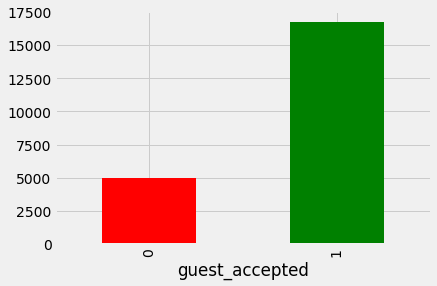

In [298]:
host_replied_by_accepted_guests = numeric_contacts[numeric_contacts['host_replied']==1][['guest_accepted']]

host_replied_by_accepted_guests.groupby('guest_accepted').size().plot(kind='bar', color=['r','g'])

In [299]:
print('Cuando host responde: ' )
print(str(round(host_replied_by_accepted_guests.groupby('guest_accepted').size()[0]*100/host_replied_by_accepted_guests.shape[0]))+"% es refused")
print(str(round(host_replied_by_accepted_guests.groupby('guest_accepted').size()[1]*100/host_replied_by_accepted_guests.shape[0]))+"% es accepted")
print("Lo que quiere decir que hay una probabilidad 70% que de ser aceptado, una vez el host responde")

Cuando host responde: 
23% es refused
77% es accepted
Lo que quiere decir que hay una probabilidad 70% que de ser aceptado, una vez el host responde


#diff_reply_interaction

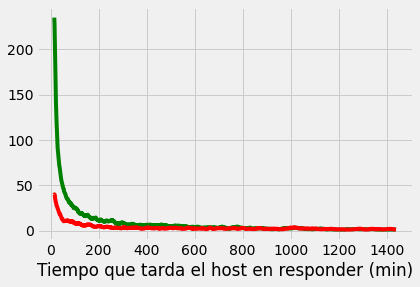

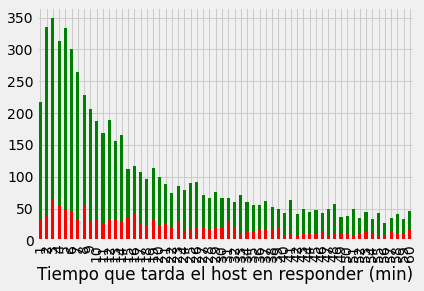

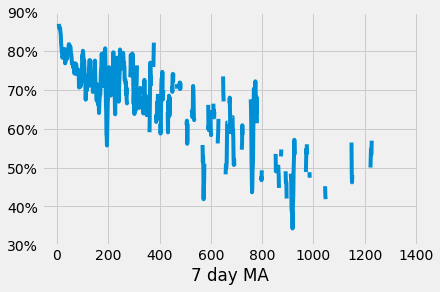

In [300]:
diff_reply_interaction_by_accepted_guests = numeric_contacts[(numeric_contacts['guest_accepted']==1)][['diff_reply_interaction']]
diff_reply_interaction_by_accepted_guests = diff_reply_interaction_by_accepted_guests[diff_reply_interaction_by_accepted_guests['diff_reply_interaction']>0]

diff_reply_interaction_by_refused_guests = numeric_contacts[(numeric_contacts['guest_accepted']==0)][['diff_reply_interaction']]
diff_reply_interaction_by_refused_guests = diff_reply_interaction_by_refused_guests[diff_reply_interaction_by_refused_guests['diff_reply_interaction']>0]

diff_reply_interaction_by_accepted_guests.groupby("diff_reply_interaction").size().rolling(window=15).mean().plot(y='size',kind='line',xlabel='Tiempo que tarda el host en responder (min)',color='green')
diff_reply_interaction_by_refused_guests.groupby("diff_reply_interaction").size().rolling(window=15).mean().plot(y='size',kind='line',xlabel='Tiempo que tarda el host en responder (min)',color='red')
plt.show()

diff_reply_interaction_by_accepted_guests_inf_firsts = numeric_contacts[(numeric_contacts['guest_accepted']==1)][['diff_reply_interaction']]
diff_reply_interaction_by_accepted_guests_inf_firsts = diff_reply_interaction_by_accepted_guests_inf_firsts[(diff_reply_interaction_by_accepted_guests_inf_firsts['diff_reply_interaction']>0)&(diff_reply_interaction_by_accepted_guests_inf_firsts['diff_reply_interaction']<=60)]

diff_reply_interaction_by_refused_guests_inf_firsts = numeric_contacts[(numeric_contacts['guest_accepted']==0)][['diff_reply_interaction']]
diff_reply_interaction_by_refused_guests_inf_firsts = diff_reply_interaction_by_refused_guests_inf_firsts[(diff_reply_interaction_by_refused_guests_inf_firsts['diff_reply_interaction']>0)&(diff_reply_interaction_by_refused_guests_inf_firsts['diff_reply_interaction']<=60)]

diff_reply_interaction_by_accepted_guests_inf_firsts.groupby("diff_reply_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo que tarda el host en responder (min)',color='green')
diff_reply_interaction_by_refused_guests_inf_firsts.groupby("diff_reply_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo que tarda el host en responder (min)',color='red')
plt.show()

prob_accepted_reply_interaction = diff_reply_interaction_by_accepted_guests.groupby("diff_reply_interaction").size()*100 / (diff_reply_interaction_by_accepted_guests.groupby("diff_reply_interaction").size()+diff_reply_interaction_by_refused_guests.groupby("diff_reply_interaction").size())
ax = prob_accepted_reply_interaction.rolling(window=7).mean().plot(x=range(1400),y=range(100),kind='line',xlabel='7 day MA')
ax.set_ylim([30,90])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()



<u> Aceptados </u>

In [345]:
print("Promedio: "+str(round(diff_reply_interaction_by_accepted_guests.mean().values[0],2))+"\n")
print("Min: "+str(diff_reply_interaction_by_accepted_guests.min().values[0])+"\n")
print("Max: "+str(diff_reply_interaction_by_accepted_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(diff_reply_interaction_by_accepted_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(diff_reply_interaction_by_accepted_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(diff_reply_interaction_by_accepted_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(diff_reply_interaction_by_accepted_guests.mode().values[0][0])+"\n")

Promedio: 221.72

Min: 1

Max: 1439

Primer cuartil: 14

Median: 74

Tercer cuartil: 309

Moda: 3



<u>Rechazados</u>

In [346]:
print("Promedio: "+str(round(diff_reply_interaction_by_refused_guests.mean().values[0],2))+"\n")
print("Min: "+str(diff_reply_interaction_by_refused_guests.min().values[0])+"\n")
print("Max: "+str(diff_reply_interaction_by_refused_guests.max().values[0])+"\n")
print("Primer cuartil: "+str(round(diff_reply_interaction_by_refused_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(diff_reply_interaction_by_refused_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(diff_reply_interaction_by_refused_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(diff_reply_interaction_by_refused_guests.mode().values[0][0])+"\n")

Promedio: 412.02

Min: 1

Max: 1439

Primer cuartil: 53

Median: 238

Tercer cuartil: 722

Moda: 3



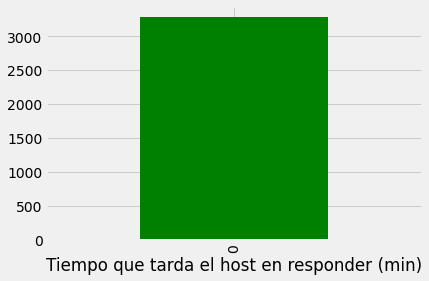

99.605% de los guest que les repondieron en menos de 1 minuto fueron aceptados
0.395% de los guest que les repondieron en menos de 1 minuto fueron rechazados


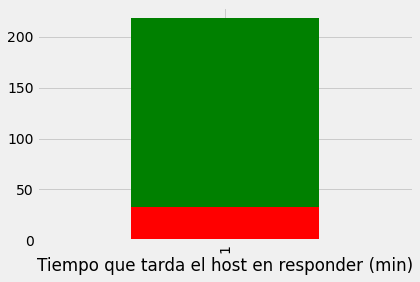

86.853% de los guest que les repondieron en menos de 1 minuto fueron aceptados
13.147% de los guest que les repondieron en menos de 1 minuto fueron rechazados


In [344]:

diff_reply_interaction_by_accepted_guests_min = numeric_contacts[(numeric_contacts['guest_accepted']==1)][['diff_reply_interaction']]
diff_reply_interaction_by_accepted_guests_min = diff_reply_interaction_by_accepted_guests_min[diff_reply_interaction_by_accepted_guests_min['diff_reply_interaction']==0]

diff_reply_interaction_by_refused_guests_min = numeric_contacts[(numeric_contacts['guest_accepted']==0)][['diff_reply_interaction']]
diff_reply_interaction_by_refused_guests_min = diff_reply_interaction_by_refused_guests_min[diff_reply_interaction_by_refused_guests_min['diff_reply_interaction']==0]


diff_reply_interaction_by_accepted_guests_min.groupby("diff_reply_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo que tarda el host en responder (min)',color='green')
diff_reply_interaction_by_refused_guests_min.groupby("diff_reply_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo que tarda el host en responder (min)',color='red')
plt.show()

print(str(round(diff_reply_interaction_by_accepted_guests_min.groupby("diff_reply_interaction").size().values[0]*100/(diff_reply_interaction_by_accepted_guests_min.shape[0]+diff_reply_interaction_by_refused_guests_min.shape[0]),3))+ "% de los guest que les repondieron en menos de 1 minuto fueron aceptados")
print(str(round(diff_reply_interaction_by_refused_guests_min.groupby("diff_reply_interaction").size().values[0]*100/(diff_reply_interaction_by_accepted_guests_min.shape[0]+diff_reply_interaction_by_refused_guests_min.shape[0]),3))+ "% de los guest que les repondieron en menos de 1 minuto fueron rechazados")

diff_reply_interaction_by_accepted_guests_one = numeric_contacts[(numeric_contacts['guest_accepted']==1)][['diff_reply_interaction']]
diff_reply_interaction_by_accepted_guests_one = diff_reply_interaction_by_accepted_guests_one[diff_reply_interaction_by_accepted_guests_one['diff_reply_interaction']==1]

diff_reply_interaction_by_refused_guests_one = numeric_contacts[(numeric_contacts['guest_accepted']==0)][['diff_reply_interaction']]
diff_reply_interaction_by_refused_guests_one = diff_reply_interaction_by_refused_guests_one[diff_reply_interaction_by_refused_guests_one['diff_reply_interaction']==1]


diff_reply_interaction_by_accepted_guests_one.groupby("diff_reply_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo que tarda el host en responder (min)',color='green')
diff_reply_interaction_by_refused_guests_one.groupby("diff_reply_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo que tarda el host en responder (min)',color='red')
plt.show()

print(str(round(diff_reply_interaction_by_accepted_guests_one.groupby("diff_reply_interaction").size().values[0]*100/(diff_reply_interaction_by_accepted_guests_one.shape[0]+diff_reply_interaction_by_refused_guests_one.shape[0]),3))+ "% de los guest que les repondieron en menos de 1 minuto fueron aceptados")
print(str(round(diff_reply_interaction_by_refused_guests_one.groupby("diff_reply_interaction").size().values[0]*100/(diff_reply_interaction_by_accepted_guests_one.shape[0]+diff_reply_interaction_by_refused_guests_one.shape[0]),3))+ "% de los guest que les repondieron en menos de 1 minuto fueron rechazados")


#diff_checkin_interaction

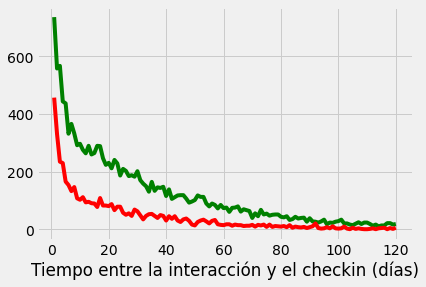

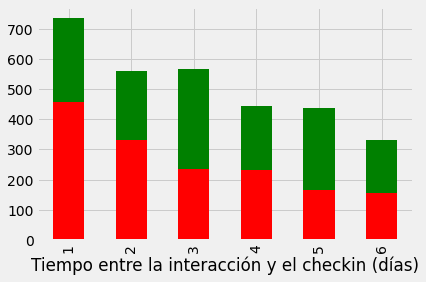

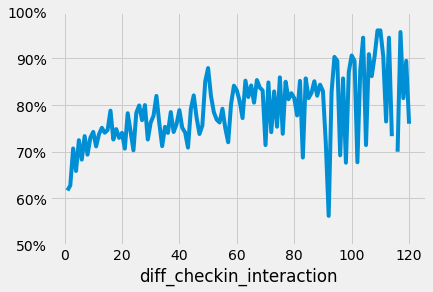

In [302]:
diff_checkin_interaction_by_accepted_guests = numeric_contacts[(numeric_contacts['guest_accepted']==1)][['diff_checkin_interaction']]
diff_checkin_interaction_by_accepted_guests = diff_checkin_interaction_by_accepted_guests[(diff_checkin_interaction_by_accepted_guests['diff_checkin_interaction']>0)&(diff_checkin_interaction_by_accepted_guests['diff_checkin_interaction']<365//3)]

diff_checkin_interaction_by_refused_guests = numeric_contacts[(numeric_contacts['guest_accepted']==0)][['diff_checkin_interaction']]
diff_checkin_interaction_by_refused_guests = diff_checkin_interaction_by_refused_guests[(diff_checkin_interaction_by_refused_guests['diff_checkin_interaction']>0)&(diff_checkin_interaction_by_refused_guests['diff_checkin_interaction']<365//3)]

diff_checkin_interaction_by_accepted_guests.groupby("diff_checkin_interaction").size().plot(y='size',kind='line',xlabel='Tiempo entre la interacción y el checkin (días)',color='green')
diff_checkin_interaction_by_refused_guests.groupby("diff_checkin_interaction").size().plot(y='size',kind='line',xlabel='Tiempo entre la interacción y el checkin (días)',color='red')
plt.show()

diff_checkin_interaction_by_accepted_guests_firsts = numeric_contacts[(numeric_contacts['guest_accepted']==1)][['diff_checkin_interaction']]
diff_checkin_interaction_by_accepted_guests_firsts = diff_checkin_interaction_by_accepted_guests_firsts[(diff_checkin_interaction_by_accepted_guests_firsts['diff_checkin_interaction']>0)&(diff_checkin_interaction_by_accepted_guests_firsts['diff_checkin_interaction']<7)]

diff_checkin_interaction_by_refused_guests_firsts = numeric_contacts[(numeric_contacts['guest_accepted']==0)][['diff_checkin_interaction']]
diff_checkin_interaction_by_refused_guests_firsts = diff_checkin_interaction_by_refused_guests_firsts[(diff_checkin_interaction_by_refused_guests_firsts['diff_checkin_interaction']>0)&(diff_checkin_interaction_by_refused_guests_firsts['diff_checkin_interaction']<7)]

diff_checkin_interaction_by_accepted_guests_firsts.groupby("diff_checkin_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo entre la interacción y el checkin (días)',color='green')
diff_checkin_interaction_by_refused_guests_firsts.groupby("diff_checkin_interaction").size().plot(y='size',kind='bar',xlabel='Tiempo entre la interacción y el checkin (días)',color='red')
plt.show()

prob_accepted_checkin_interaction = diff_checkin_interaction_by_accepted_guests.groupby("diff_checkin_interaction").size()*100 / (diff_checkin_interaction_by_accepted_guests.groupby("diff_checkin_interaction").size()+diff_checkin_interaction_by_refused_guests.groupby("diff_checkin_interaction").size())
ax = prob_accepted_checkin_interaction.plot(y=range(100),kind='line')
ax.set_ylim([50,100])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


In [363]:

print("Primer cuartil: "+str(round(diff_checkin_interaction_by_accepted_guests.quantile(0.25).values[0]))+"\n")
print("Median: "+str(round(diff_checkin_interaction_by_accepted_guests.quantile(0.5).values[0]))+"\n")
print("Tercer cuartil: "+str(round(diff_checkin_interaction_by_accepted_guests.quantile(0.75).values[0]))+"\n")
print("Moda: "+str(diff_checkin_interaction_by_accepted_guests.mode().values[0][0])+"\n")

Primer cuartil: 8

Median: 22

Tercer cuartil: 45

Moda: 1



#stay

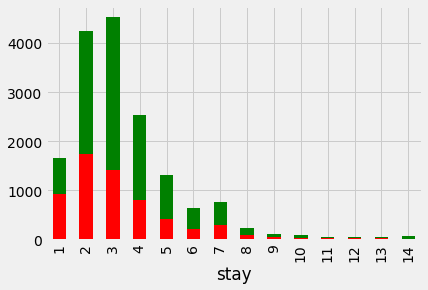

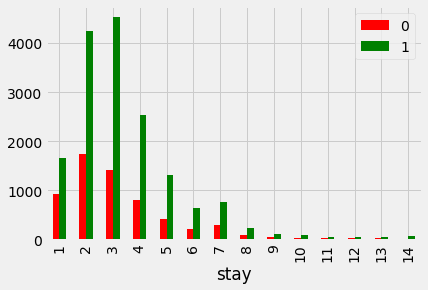

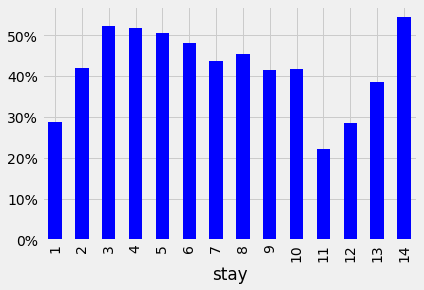

In [303]:
stay_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['stay']]
stay_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['stay']]

stay_by_accepted_guests = stay_by_accepted_guests[stay_by_accepted_guests['stay']<15]
stay_by_refused_guests = stay_by_refused_guests[stay_by_refused_guests['stay']<15]

stay_by_accepted_guests.groupby('stay').size().plot(kind='bar', color='g')
stay_by_refused_guests.groupby('stay').size().plot(kind='bar', color='r')
plt.show()

df = pd.concat([stay_by_refused_guests.groupby('stay').size(),stay_by_accepted_guests.groupby('stay').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()

prob_accepted_stay = 100*(stay_by_accepted_guests.groupby("stay").size() - stay_by_refused_guests.groupby("stay").size())/ (stay_by_accepted_guests.groupby("stay").size()+stay_by_refused_guests.groupby("stay").size())
ax = prob_accepted_stay.plot(y=range(100),kind='bar',color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


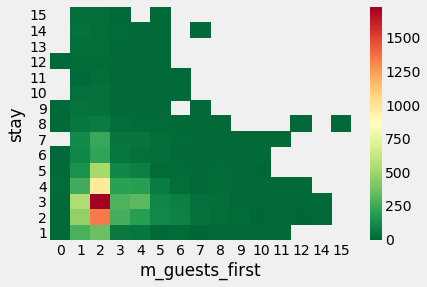

In [304]:
stay_by_m_guests_first = numeric_contacts[['stay','m_guests_first','guest_accepted']]
stay_by_m_guests_first.loc[stay_by_m_guests_first['guest_accepted'] == 0, 'guest_accepted'] = -1
stay_by_m_guests_first = stay_by_m_guests_first[stay_by_m_guests_first['stay']<=15]
capacity_guest_matrix =  stay_by_m_guests_first.pivot_table(index='stay',columns='m_guests_first',values='guest_accepted', aggfunc = "sum")
g=sns.heatmap(capacity_guest_matrix ,annot=False,cmap="RdYlGn_r")
g.invert_yaxis()

#checkin_month

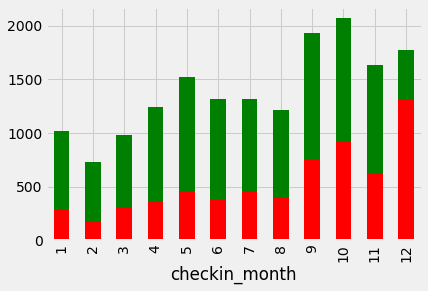

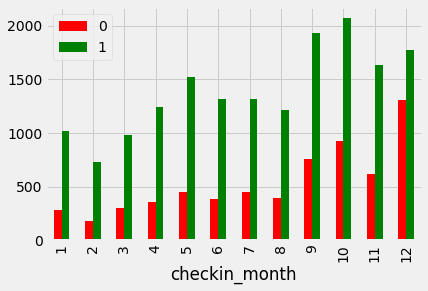

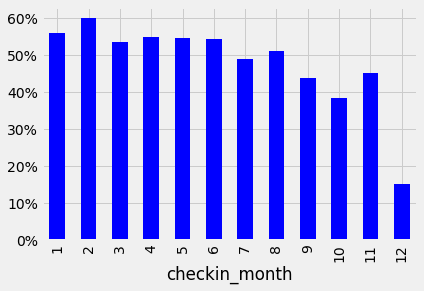

In [305]:
checkin_month_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['checkin_month']]
checkin_month_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['checkin_month']]

checkin_month_by_accepted_guests.groupby('checkin_month').size().plot(kind='bar', color='g')
checkin_month_by_refused_guests.groupby('checkin_month').size().plot(kind='bar', color='r')
plt.show()

df = pd.concat([checkin_month_by_refused_guests.groupby('checkin_month').size(),checkin_month_by_accepted_guests.groupby('checkin_month').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()


prob_accepted_checkin_month = 100*(checkin_month_by_accepted_guests.groupby("checkin_month").size() - checkin_month_by_refused_guests.groupby("checkin_month").size())/ (checkin_month_by_accepted_guests.groupby("checkin_month").size()+checkin_month_by_refused_guests.groupby("checkin_month").size())
ax = prob_accepted_checkin_month.plot(y=range(100),kind='bar',color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#checkin weekday

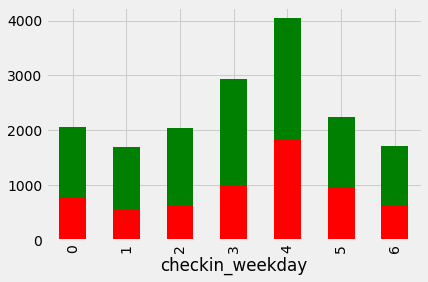

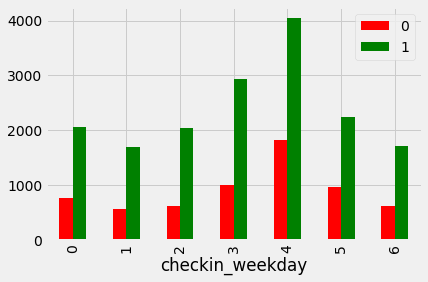

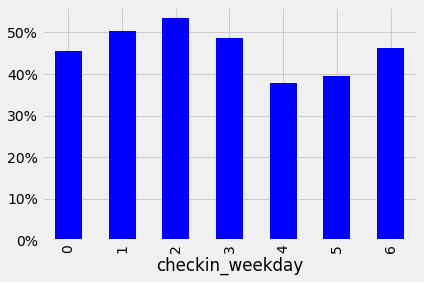

In [306]:
checkin_weekday_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['checkin_weekday']]
checkin_weekday_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['checkin_weekday']]

checkin_weekday_by_accepted_guests.groupby('checkin_weekday').size().plot(kind='bar', color='g')
checkin_weekday_by_refused_guests.groupby('checkin_weekday').size().plot(kind='bar', color='r')
plt.show()

df = pd.concat([checkin_weekday_by_refused_guests.groupby('checkin_weekday').size(),checkin_weekday_by_accepted_guests.groupby('checkin_weekday').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()


prob_accepted_checkin_weekday = 100*(checkin_weekday_by_accepted_guests.groupby("checkin_weekday").size() - checkin_weekday_by_refused_guests.groupby("checkin_weekday").size())/ (checkin_weekday_by_accepted_guests.groupby("checkin_weekday").size()+checkin_weekday_by_refused_guests.groupby("checkin_weekday").size())
ax = prob_accepted_checkin_weekday.plot(y=range(100),kind='bar',color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#interaction_month

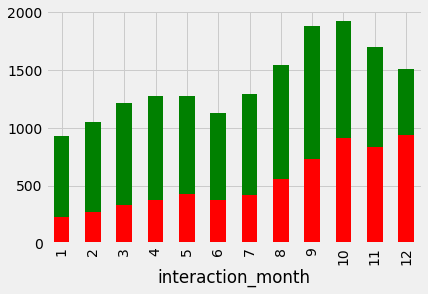

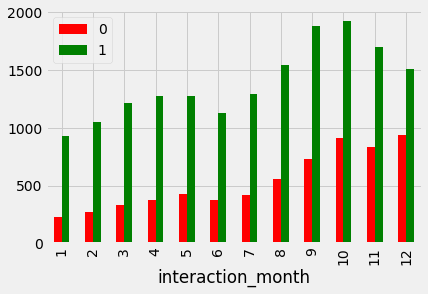

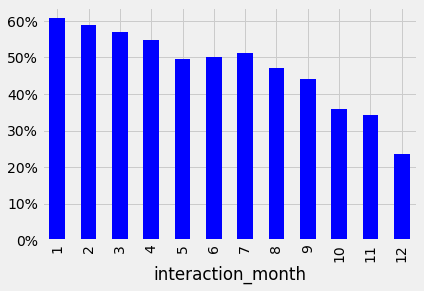

In [307]:
interaction_month_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['interaction_month']]
interaction_month_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['interaction_month']]

interaction_month_by_accepted_guests.groupby('interaction_month').size().plot(kind='bar', color='g')
interaction_month_by_refused_guests.groupby('interaction_month').size().plot(kind='bar', color='r')
plt.show()

df = pd.concat([interaction_month_by_refused_guests.groupby('interaction_month').size(),interaction_month_by_accepted_guests.groupby('interaction_month').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()


prob_accepted_interaction_month = 100*(interaction_month_by_accepted_guests.groupby("interaction_month").size() - interaction_month_by_refused_guests.groupby("interaction_month").size()) / (interaction_month_by_accepted_guests.groupby("interaction_month").size()+interaction_month_by_refused_guests.groupby("interaction_month").size())
ax = prob_accepted_interaction_month.plot(y=range(100),kind='bar',color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#interaction hour and weekday

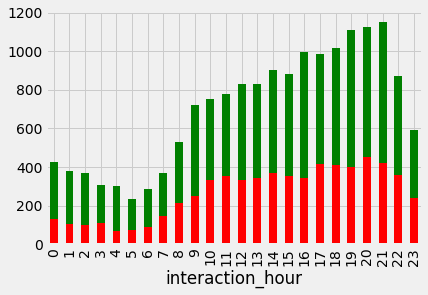

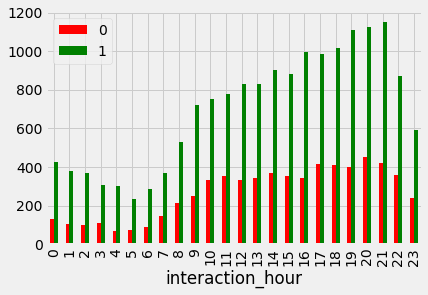

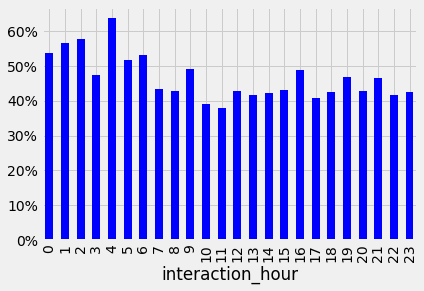

In [308]:
interaction_hour_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['interaction_hour']]
interaction_hour_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['interaction_hour']]

interaction_hour_by_accepted_guests.groupby('interaction_hour').size().plot(kind='bar', color='g')
interaction_hour_by_refused_guests.groupby('interaction_hour').size().plot(kind='bar', color='r')
plt.show()

df = pd.concat([interaction_hour_by_refused_guests.groupby('interaction_hour').size(),interaction_hour_by_accepted_guests.groupby('interaction_hour').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()


prob_accepted_interaction_hour = 100*(interaction_hour_by_accepted_guests.groupby("interaction_hour").size() - interaction_hour_by_refused_guests.groupby("interaction_hour").size()) / (interaction_hour_by_accepted_guests.groupby("interaction_hour").size()+interaction_hour_by_refused_guests.groupby("interaction_hour").size())
ax = prob_accepted_interaction_hour.plot(y=range(100),kind='bar',color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

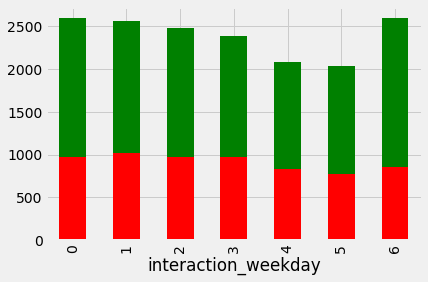

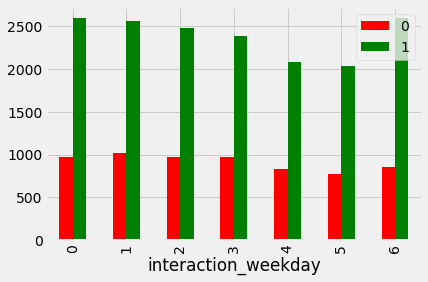

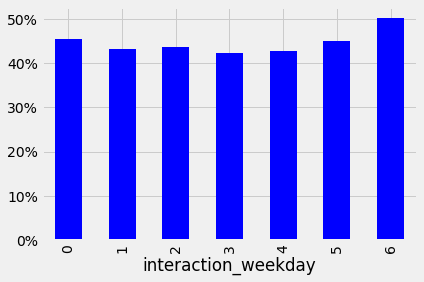

In [309]:
interaction_weekday_by_accepted_guests = numeric_contacts[numeric_contacts['guest_accepted']==1][['interaction_weekday']]
interaction_weekday_by_refused_guests = numeric_contacts[numeric_contacts['guest_accepted']==0][['interaction_weekday']]

interaction_weekday_by_accepted_guests.groupby('interaction_weekday').size().plot(kind='bar', color='g')
interaction_weekday_by_refused_guests.groupby('interaction_weekday').size().plot(kind='bar', color='r')
plt.show()

df = pd.concat([interaction_weekday_by_refused_guests.groupby('interaction_weekday').size(),interaction_weekday_by_accepted_guests.groupby('interaction_weekday').size()], axis=1, ignore_index=True)
df.plot.bar(color=['r','g'])
plt.show()


prob_accepted_interaction_weekday = 100*(interaction_weekday_by_accepted_guests.groupby("interaction_weekday").size() - interaction_weekday_by_refused_guests.groupby("interaction_weekday").size()) / (interaction_weekday_by_accepted_guests.groupby("interaction_weekday").size()+interaction_weekday_by_refused_guests.groupby("interaction_weekday").size())
ax = prob_accepted_interaction_weekday.plot(y=range(100),kind='bar',color='b')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


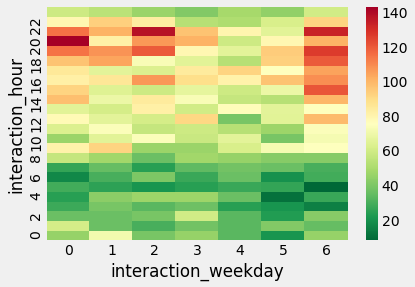

In [310]:
interaction_hour_by_interaction_weekday = numeric_contacts[['interaction_hour','interaction_weekday','guest_accepted']]
interaction_hour_by_interaction_weekday.loc[interaction_hour_by_interaction_weekday['guest_accepted'] == 0, 'guest_accepted'] = -1
capacity_guest_matrix =  interaction_hour_by_interaction_weekday.pivot_table(index='interaction_hour',columns='interaction_weekday',values='guest_accepted', aggfunc = "sum")
g=sns.heatmap(capacity_guest_matrix ,annot=False,cmap="RdYlGn_r")
g.invert_yaxis()

#Pasado de guests

In [311]:
inquiries_per_guest = contacts.groupby('id_guest_anon').size()
times_accepted_by_guest = contacts[contacts['guest_accepted']==1].groupby('id_guest_anon').size()
times_refused_by_guest = contacts[contacts['guest_accepted']==0].groupby('id_guest_anon').size()
past_guest_acceptance = pd.concat([times_accepted_by_guest,times_accepted_by_guest*100/inquiries_per_guest, times_refused_by_guest,times_refused_by_guest*100/inquiries_per_guest,inquiries_per_guest], axis=1).fillna(0).reset_index()
past_guest_acceptance.columns=['id_guest_anon','times_guest_accepted','times_guest_accepted_perc','times_guest_refused','times_guest_refused_perc','numb_of_inquiries']

In [312]:
past_guest_acceptance

,id_guest_anon,times_guest_accepted,times_guest_accepted_perc,times_guest_refused,times_guest_refused_perc,numb_of_inquiries
0,000925af-ad49-431e-9996-47a737295a85,1.0,100.0,0.0,0.0,1
1,000f8174-8cb4-4cba-b76b-3b9e27207e95,1.0,100.0,0.0,0.0,1
2,00117aa8-5c8d-4b6d-9d77-c25c605dc67c,1.0,100.0,0.0,0.0,1
3,0011c3f0-f472-4b15-a18d-429759d5b611,1.0,100.0,0.0,0.0,1
4,001274e8-3195-4020-9853-407c34a977ee,1.0,100.0,0.0,0.0,1
...,...,...,...,...,...,...
18174,ff6359b7-6814-460d-8b7d-ab4b58b62a7f,0.0,0.0,1.0,100.0,1
18175,ff6930a8-7d01-46ef-90a0-4a05acf549e1,0.0,0.0,1.0,100.0,1
18176,ff9dc4f9-7724-454c-bf88-116d125ba3d0,0.0,0.0,1.0,100.0,1
18177,ffb4039e-b0dc-4f55-b476-56fa32a33950,0.0,0.0,1.0,100.0,1


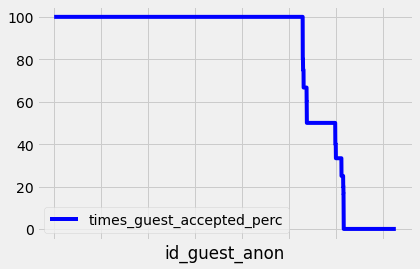

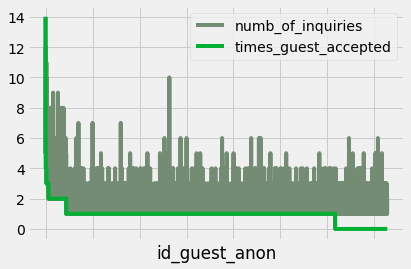

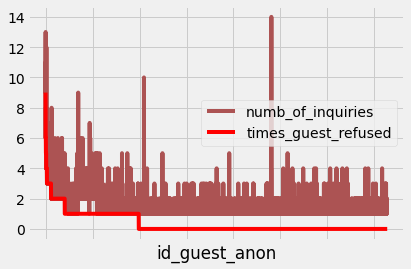

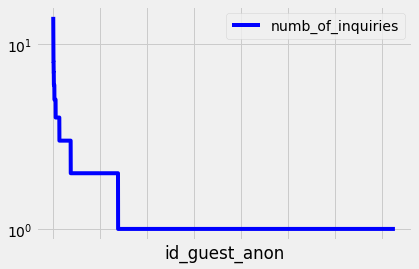

In [313]:
past_guest_acceptance.sort_values(by='times_guest_accepted_perc',ascending=False).plot(x='id_guest_anon', y='times_guest_accepted_perc', kind='line',color='blue')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

past_guest_acceptance.sort_values(by='times_guest_accepted',ascending=False).plot(x='id_guest_anon', y=['numb_of_inquiries','times_guest_accepted'], kind='line',color=['#738c73','#00b032'])
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

past_guest_acceptance.sort_values(by='times_guest_refused',ascending=False).plot(x='id_guest_anon', y=['numb_of_inquiries','times_guest_refused'], kind='line',color=['#ac5353','#ff0000'])
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

ax = past_guest_acceptance.sort_values(by='numb_of_inquiries',ascending=False).plot(x='id_guest_anon', y='numb_of_inquiries', kind='line',color='b')
ax.set_yscale('log')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

In [314]:
past_guest_acceptance_mean = past_guest_acceptance.mean()
past_guest_acceptance_centiles = past_guest_acceptance.quantile([x*0.1 for x in range(1,10)])
past_guest_acceptance_max = past_guest_acceptance.max()
past_guest_acceptance_std = past_guest_acceptance.std()

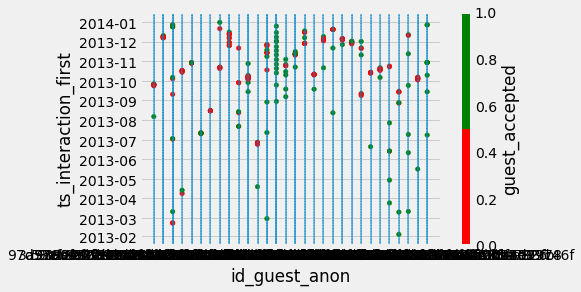

In [315]:
active_guests = past_guest_acceptance[past_guest_acceptance['numb_of_inquiries']>=7]
guest_acceptance_by_time = contacts[contacts['id_guest_anon'].isin(active_guests['id_guest_anon'])]
guest_acceptance_by_time = guest_acceptance_by_time[['id_guest_anon','ts_interaction_first','guest_accepted']]

cmap = colors.ListedColormap(['red', 'green'])
guest_acceptance_by_time.plot.scatter(x='id_guest_anon',y='ts_interaction_first', c='guest_accepted',colormap=cmap )
for line in guest_acceptance_by_time['id_guest_anon'].values:
  plt.axvline(line,linewidth=0.3,linestyle='--')

plt.show()

#Pasado de Hosts

In [316]:
inquiries_per_host = contacts.groupby('id_host_anon').size()
times_accepted_by_host = contacts[contacts['guest_accepted']==1].groupby('id_host_anon').size()
times_refused_by_host = contacts[contacts['guest_accepted']==0].groupby('id_host_anon').size()
past_host_acceptance = pd.concat([times_accepted_by_host,times_accepted_by_host*100/inquiries_per_host, times_refused_by_host,times_refused_by_host*100/inquiries_per_host,inquiries_per_host], axis=1).fillna(0).reset_index()
past_host_acceptance.columns=['id_host_anon','times_host_accepted','times_host_accepted_perc','times_host_refused','times_host_refused_perc','numb_of_inquiries']

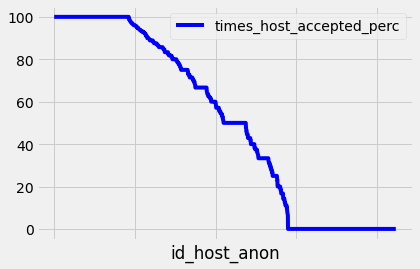

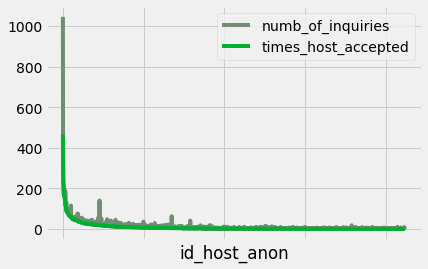

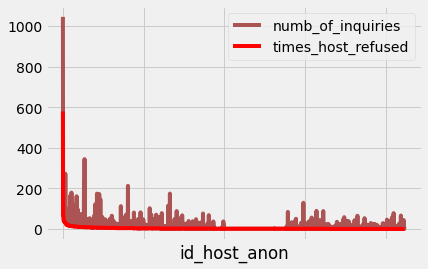

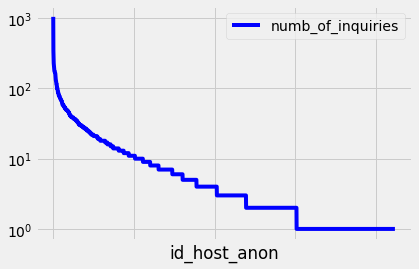

In [317]:
past_host_acceptance.sort_values(by='times_host_accepted_perc',ascending=False).plot(x='id_host_anon', y='times_host_accepted_perc', kind='line',color='blue')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

past_host_acceptance.sort_values(by='times_host_accepted',ascending=False).plot(x='id_host_anon', y=['numb_of_inquiries','times_host_accepted'], kind='line',color=['#738c73','#00b032'])
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

past_host_acceptance.sort_values(by='times_host_refused',ascending=False).plot(x='id_host_anon', y=['numb_of_inquiries','times_host_refused'], kind='line',color=['#ac5353','#ff0000'])
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

ax = past_host_acceptance.sort_values(by='numb_of_inquiries',ascending=False).plot(x='id_host_anon', y='numb_of_inquiries', kind='line',color='b')
ax.set_yscale('log')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

In [318]:
past_host_acceptance_mean = past_host_acceptance.mean()
past_host_acceptance_centiles = past_host_acceptance.quantile([x*0.1 for x in range(1,10)])
past_host_acceptance_max = past_host_acceptance.max()
past_host_acceptance_std = past_host_acceptance.std()

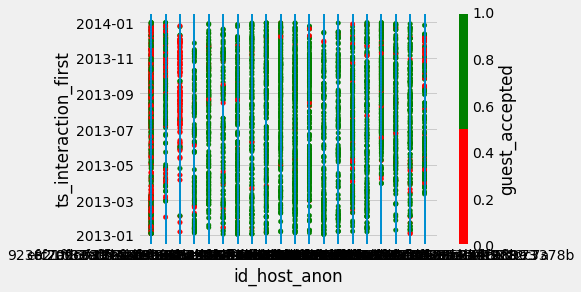

In [319]:
active_hosts = past_host_acceptance[past_host_acceptance['numb_of_inquiries']>=120]
host_acceptance_by_time = contacts[contacts['id_host_anon'].isin(active_hosts['id_host_anon'])]
host_acceptance_by_time = host_acceptance_by_time[['id_host_anon','ts_interaction_first','guest_accepted']]

cmap = colors.ListedColormap(['red', 'green'])
host_acceptance_by_time.plot.scatter(x='id_host_anon',y='ts_interaction_first', c='guest_accepted',colormap=cmap )
for line in host_acceptance_by_time['id_host_anon'].values:
  plt.axvline(line,linewidth=0.3,linestyle='--')

plt.show()

#Pasado de listings

In [320]:
inquiries_per_listing = contacts.groupby('id_listing_anon').size()
times_accepted_by_listing = contacts[contacts['guest_accepted']==1].groupby('id_listing_anon').size()
times_refused_by_listing = contacts[contacts['guest_accepted']==0].groupby('id_listing_anon').size()
past_listing_acceptance = pd.concat([times_accepted_by_listing,times_accepted_by_listing*100/inquiries_per_listing, times_refused_by_listing,times_refused_by_listing*100/inquiries_per_listing,inquiries_per_listing], axis=1).fillna(0).reset_index()
past_listing_acceptance.columns=['id_listing_anon','times_listing_accepted','times_listing_accepted_perc','times_listing_refused','times_listing_refused_perc','numb_of_inquiries']

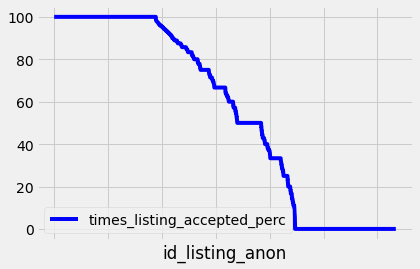

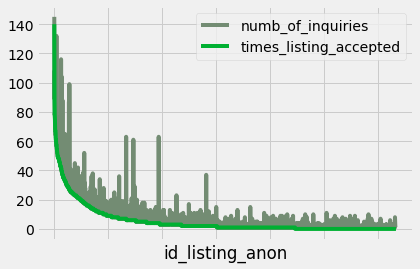

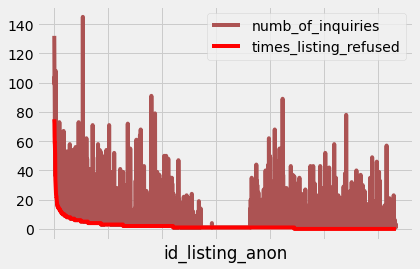

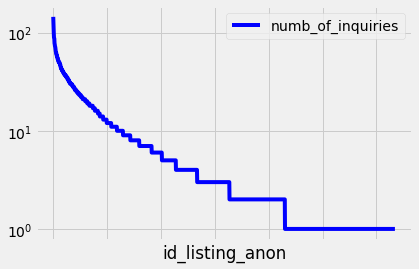

In [321]:
past_listing_acceptance.sort_values(by='times_listing_accepted_perc',ascending=False).plot(x='id_listing_anon', y='times_listing_accepted_perc', kind='line',color='blue')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

past_listing_acceptance.sort_values(by='times_listing_accepted',ascending=False).plot(x='id_listing_anon', y=['numb_of_inquiries','times_listing_accepted'], kind='line',color=['#738c73','#00b032'])
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

past_listing_acceptance.sort_values(by='times_listing_refused',ascending=False).plot(x='id_listing_anon', y=['numb_of_inquiries','times_listing_refused'], kind='line',color=['#ac5353','#ff0000'])
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

ax = past_listing_acceptance.sort_values(by='numb_of_inquiries',ascending=False).plot(x='id_listing_anon', y='numb_of_inquiries', kind='line',color='b')
ax.set_yscale('log')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()


In [322]:
past_listing_acceptance_mean = past_listing_acceptance.mean()
past_listing_acceptance_centiles = past_listing_acceptance.quantile([x*0.1 for x in range(1,10)])
past_listing_acceptance_max = past_listing_acceptance.max()
past_listing_acceptance_std = past_listing_acceptance.std()

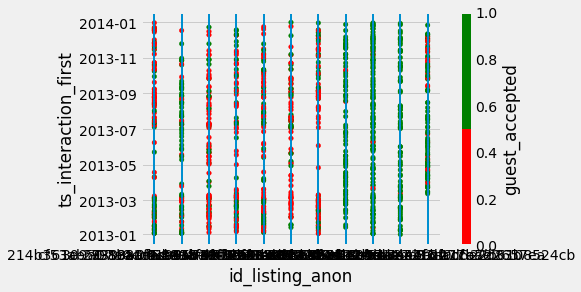

In [323]:
active_listings = past_listing_acceptance[past_listing_acceptance['numb_of_inquiries']>=80]
listing_acceptance_by_time = contacts[contacts['id_listing_anon'].isin(active_listings['id_listing_anon'])]
listing_acceptance_by_time = listing_acceptance_by_time[['id_listing_anon','ts_interaction_first','guest_accepted']]

cmap = colors.ListedColormap(['red', 'green'])
listing_acceptance_by_time.plot.scatter(x='id_listing_anon',y='ts_interaction_first', c='guest_accepted',colormap=cmap )
for line in listing_acceptance_by_time['id_listing_anon'].values:
  plt.axvline(line,linewidth=0.3,linestyle='--')

plt.show()

#Listings by host

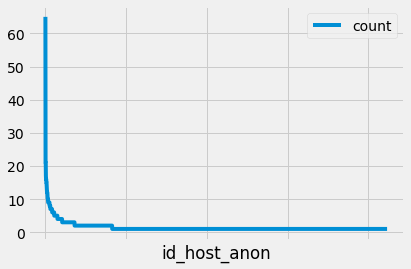

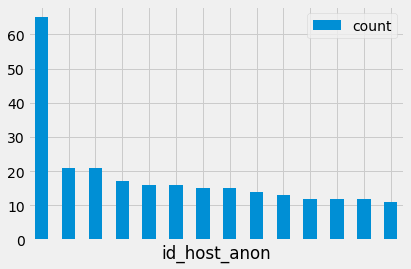

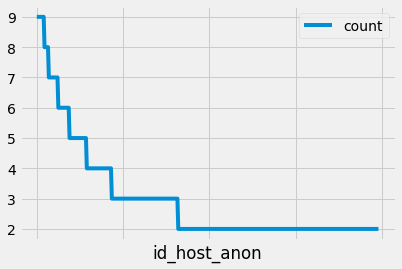

In [324]:
listings_by_host = pd.DataFrame(contacts.groupby(['id_host_anon','id_listing_anon']).size()).groupby('id_host_anon').count()
listings_by_host.columns = ['count']
listings_by_host.sort_values(by="count",ascending=False).reset_index().plot(x="id_host_anon",y="count",kind='line')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

listings_by_host[listings_by_host['count']>10].sort_values(by="count",ascending=False).reset_index().plot(x="id_host_anon",y="count",kind='bar')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

listings_by_host[(listings_by_host['count']<10)&(listings_by_host['count']>1)].sort_values(by="count",ascending=False).reset_index().plot(x="id_host_anon",y="count",kind='line')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

In [325]:
listings_by_host_mean = listings_by_host.mean()
listings_by_host_centiles = listings_by_host.quantile([x*0.1 for x in range(1,10)])
listings_by_host_max = listings_by_host.max()
listings_by_host_std = listings_by_host.std()

#Random forest

Dummies para variables ordinales

In [326]:
features = numeric_contacts

In [327]:
labels = np.array(features['guest_accepted'])
features= features.drop('guest_accepted', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

In [328]:
features

array([[  2,  13, 165, ...,   6,   1,   1],
       [  2,   5,   0, ...,   1,   1,   1],
       [  2,   7, 350, ...,   1,   5,   3],
       ...,
       [  2,   2, 282, ...,   3,  12,  12],
       [  2,  10, 215, ...,   1,  12,  12],
       [  3,  15,  89, ...,   6,  12,  12]])

In [329]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [330]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (17357, 15)
Training Labels Shape: (17357,)
Testing Features Shape: (5786, 15)
Testing Labels Shape: (5786,)


In [331]:

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels);

In [341]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', metrics.mean_absolute_error(predictions, test_labels))
print('Mean Squared Error:', metrics.mean_squared_error(predictions, test_labels))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(predictions, test_labels)))

Mean Absolute Error: 0.1999996543380574
Mean Squared Error: 0.10166087037677152
Root Mean Squared Error: 0.31884301839113793


In [333]:
tree = rf.estimators_[5]
tree = rf.estimators_[5]

export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


In [334]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)

tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [335]:
importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: m_interactions       Importance: 0.29
Variable: diff_reply_interaction Importance: 0.19
Variable: dim_total_reviews    Importance: 0.11
Variable: m_first_message_length_in_characters Importance: 0.06
Variable: diff_checkin_interaction Importance: 0.06
Variable: dim_person_capacity  Importance: 0.04
Variable: host_replied         Importance: 0.04
Variable: interaction_hour     Importance: 0.04
Variable: stay                 Importance: 0.03
Variable: checkin_weekday      Importance: 0.03
Variable: interaction_weekday  Importance: 0.03
Variable: checkin_month        Importance: 0.03
Variable: interaction_month    Importance: 0.03
Variable: m_guests_first       Importance: 0.02
Variable: dim_room_type        Importance: 0.01


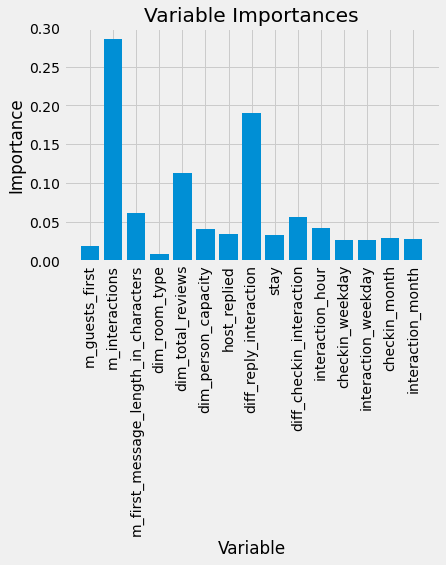

In [342]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

#140 char experiment

In [442]:
assignments = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/assignments.csv",sep=',')

In [443]:
assignments

,id_user_anon,ab
0,3e3b1bc7-9c46-4798-b955-8ed3f6bdf841,treatment
1,99fef26b-5b8c-4d96-b6f4-552a951512d6,treatment
2,25886018-ed8c-4c40-9915-ead001e2c021,control
3,f7e16080-c7ae-4e46-8247-26f92d4495a6,treatment
4,9c2d741a-acfe-4728-ba3b-0571bfd82306,treatment
...,...,...
19991,f65f9606-a9e4-4362-9600-49e1ab4086bc,control
19992,ad6ee9c9-64b6-4ff8-93f8-30f36d290fef,treatment
19993,8ed9f0f0-3e4d-4773-aed6-0338b1ad7a69,control
19994,f9a59e10-6e9c-4d1b-8e65-db0e7e0af195,control


In [444]:
assignments.dtypes

id_user_anon    object
ab              object
dtype: object

In [459]:
experiment = pd.merge(contacts, assignments, left_on='id_guest_anon', right_on='id_user_anon').drop(columns=["ab_x","id_user_anon"])
false_treatment = experiment[(experiment.ab_y=='treatment')&(experiment.m_first_message_length_in_characters<140)]
experiment = experiment[~experiment['id_guest_anon'].isin(false_treatment['id_guest_anon'])]

25522
22406


In [470]:
conversion_rates = experiment.groupby('ab_y')['guest_accepted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['acceptance_rate', 'std_deviation', 'std_error']


conversion_rates

,acceptance_rate,std_deviation,std_error
ab_y,,,
control,0.727523,0.445234,0.004009
treatment,0.740741,0.438228,0.004367


(0.0, 1.0)

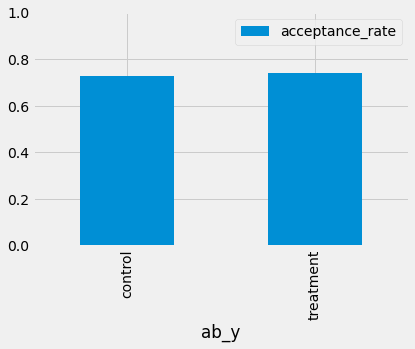

In [467]:
conversion_rates.plot(y='acceptance_rate', kind='bar')
plt.ylim(0, 1)

In [473]:
control_results = experiment[experiment['ab_y'] == 'control']['guest_accepted']
treatment_results = experiment[experiment['ab_y'] == 'treatment']['guest_accepted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.23
p-value: 0.026
ci 95% for control group: [0.720, 0.735]
ci 95% for treatment group: [0.732, 0.749]
